# Defining single-chain Structure Factor

### How to evaluate:
1) Fourier transform of pair correlation function (466 Lec 4)

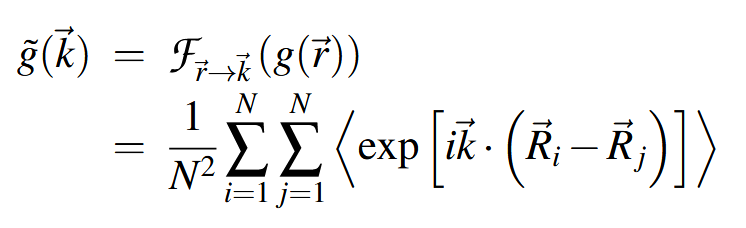


    a) Laplace inversion of wlc Green's function in Fourier-Laplace space (wlcstat doc)
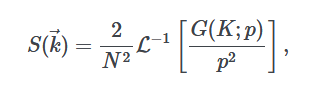
    


2) I_s(q) / I_s(q=0) (466 Lec 7, Rubinstein 2.8.2)
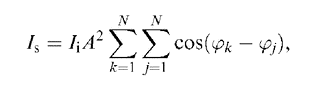
 
### Why it matters:

 "correlating scattering experiments with theoretical models provides insight into the physical behavior in polymeric fluids"
 
 generally, can tell error in [R_ij] -> at small scattering wavevector q, can compare <R_g^2>
 
 Experimentally verify theory polymer behavior in presence of different solvents

Fundamentally, any structure facot is essentially letting you know about how densities correlate
AB structure factor- at some position with vol frac A, what is the probability of vol frac B a certain distance away

#### meaning of single-chain?
Experimental result is a summation of monomer on a chain- makes sense

Analytical result (at small q) averaging over ensemble? single chain != in isolation?

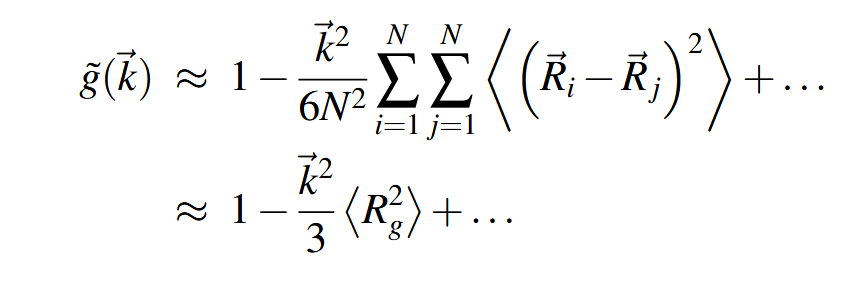



#### How does solvent enviroment impact these results?

structure factor essentially only depends on chain conformation and scattering wavevector


but, for the analytical solution, introducing interactions (bead-bead, bead-solvent) would change polymer conformations


Are these interactions considered in the evaluation of structure factor? (quasi-chemical solution model

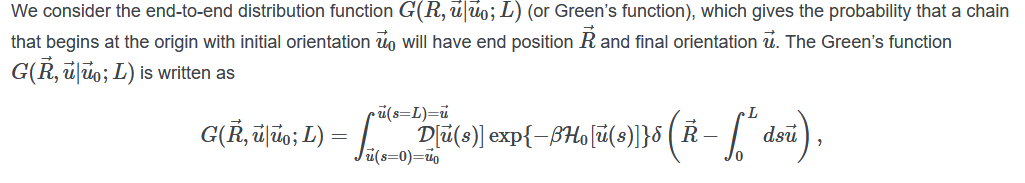

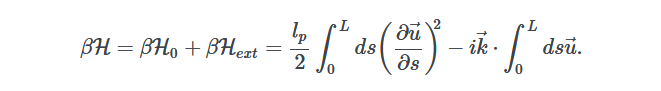

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!
import matplotlib.cm as cm
import sys
from wlcstat.wlcstruc import *
import itertools

#for data processing
import os
import operator
import xlrd

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
import seaborn as sns

Two appraoches: 

- Fourier transform of pair correlation function
- Ratio of I_scattered(q) / I_scattered(q=0)

### Simulation data:

# AB melt:

# lambda = 0 (ideal random), N_m = 0.05 (rigid)

##### chi = 0 lambda = 0, N_m = 0.05 (rigid)

In [4]:
r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=0.00_lam=0_rigid/all_rs/"
consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=0.00_lam=0_rigid/consts.txt"
chi0_lam0_melt = [r_path, consts_path]

n_p = 2000

# lambda = -.5 (biased alternating), N_m = 5 (flexible)

##### chi = 0 lambda = -.5 (biased alternating), N_m = 5 (flexible)

In [5]:
chi_zero_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=0.00_lam=-.5_flexible/all_rs/"
chi_zero_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=0.00_lam=-.5_flexible/consts.txt"
chi0_melt = [chi_zero_r_path, chi_zero_consts_path]

n_p = 2000

##### chi = 1.666 (2 * X_s)  lambda = -.5 (biased alternating), N_m = 5 (flexible)

In [6]:
chi_1p66_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=1.66_lam=-.5_flexible/all_rs/"
chi_1p66_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=1.66_lam=-.5_flexible/consts.txt"
chi1p66 = [chi_1p66_r_path, chi_1p66_consts_path]

n_p = 2000

##### chi = 3 (~4 * X_s)  lambda = -.5 (biased alternating), N_m = 5 (flexible)

In [7]:
chi_3p00_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=3.00_lam=-.5_flexible/all_rs/"
chi_3p00_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=3.00_lam=-.5_flexible/consts.txt"
chi3p00 = [chi_3p00_r_path, chi_3p00_consts_path]

n_p = 2000

##### chi = 4 (~5 * X_s)  lambda = -.5 (biased alternating), N_m = 5 (flexible)

In [8]:
chi_4p00_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=4.00_lam=-.5_flexible/all_rs/"
chi_4p00_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=4.00_lam=-.5_flexible/consts.txt"
chi4p00 = [chi_4p00_r_path, chi_4p00_consts_path]

n_p = 2000

# AB solution:

#### all RIGID, IDEALLY RANDOM

# original sim- non-interacting solvent (X_as = X_bs = 0)

## 1000 polymers- phi_p = 0.5

In [9]:
#X = 0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.00_lam=0_rigid/consts.txt"
chi0_1000_orig = [chi_r_path, chi_consts_path]

#X = 0.2
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.20_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.20_lam=0_rigid/consts.txt"
chi0p2_1000_orig = [chi_r_path, chi_consts_path]

#X = 0.4
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.40_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.40_lam=0_rigid/consts.txt"
chi0p4_1000_orig = [chi_r_path, chi_consts_path]

#X = 0.6
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.60_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.60_lam=0_rigid/consts.txt"
chi0p6_1000_orig = [chi_r_path, chi_consts_path]

#X = 0.8
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.80_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=0.80_lam=0_rigid/consts.txt"
chi0p8_1000_orig = [chi_r_path, chi_consts_path]

#X = 1.0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=1.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/original/X=1.00_lam=0_rigid/consts.txt"
chi1_1000_orig = [chi_r_path, chi_consts_path]

n_p = 1000

## 1250 polymers

## 1500 polymers

## 1750 polymers

## 2000 polymers

In [9]:
#X = 0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.00_lam=0_rigid/consts.txt"
chi0_2000_orig = [chi_r_path, chi_consts_path]

#X = 0.2
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.20_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.20_lam=0_rigid/consts.txt"
chi0p2_2000_orig = [chi_r_path, chi_consts_path]

#X = 0.4
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.40_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.40_lam=0_rigid/consts.txt"
chi0p4_2000_orig = [chi_r_path, chi_consts_path]

#X = 0.6
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.60_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.60_lam=0_rigid/consts.txt"
chi0p6_2000_orig = [chi_r_path, chi_consts_path]

#X = 0.8
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.80_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=0.80_lam=0_rigid/consts.txt"
chi0p8_2000_orig = [chi_r_path, chi_consts_path]

#X = 1.0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=1.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/original/X=1.00_lam=0_rigid/consts.txt"
chi1_2000_orig = [chi_r_path, chi_consts_path]

n_p = 2000

# edited sim- selective solvent (X_ab = X_bs, X_as = 0)

## 1000 polymers

In [103]:
#X = 0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.00_lam=0_rigid/consts.txt"
chi0_1000_edit = [chi_r_path, chi_consts_path]

#X = 0.2
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.20_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.20_lam=0_rigid/consts.txt"
chi0p2_1000_edit = [chi_r_path, chi_consts_path]

#X = 0.4
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.40_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.40_lam=0_rigid/consts.txt"
chi0p4_1000_edit = [chi_r_path, chi_consts_path]

#X = 0.6
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.60_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.60_lam=0_rigid/consts.txt"
chi0p6_1000_edit = [chi_r_path, chi_consts_path]

#X = 0.8
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.80_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=0.80_lam=0_rigid/consts.txt"
chi0p8_1000_edit = [chi_r_path, chi_consts_path]

#X = 1.0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=1.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1000_polymers/edited/X=1.00_lam=0_rigid/consts.txt"
chi1_1000_edit = [chi_r_path, chi_consts_path]

n_p = 1000

## 1250 polymers

In [104]:
#X = 0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.00_lam=0_rigid/consts.txt"
chi0_1250_edit = [chi_r_path, chi_consts_path]

#X = 0.2
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.20_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.20_lam=0_rigid/consts.txt"
chi0p2_1250_edit = [chi_r_path, chi_consts_path]

#X = 0.4
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.40_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.40_lam=0_rigid/consts.txt"
chi0p4_1250_edit = [chi_r_path, chi_consts_path]

#X = 0.6
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.60_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.60_lam=0_rigid/consts.txt"
chi0p6_1250_edit = [chi_r_path, chi_consts_path]

#X = 0.8
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.80_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=0.80_lam=0_rigid/consts.txt"
chi0p8_1250_edit = [chi_r_path, chi_consts_path]

#X = 1.0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=1.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1250_polymers/edited/X=1.00_lam=0_rigid/consts.txt"
chi1_1250_edit = [chi_r_path, chi_consts_path]

n_p = 1250

## 1500 polymers

In [105]:
#X = 0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.00_lam=0_rigid/consts.txt"
chi0_1500_edit = [chi_r_path, chi_consts_path]

#X = 0.2
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.20_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.20_lam=0_rigid/consts.txt"
chi0p2_1500_edit = [chi_r_path, chi_consts_path]

#X = 0.4
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.40_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.40_lam=0_rigid/consts.txt"
chi0p4_1500_edit = [chi_r_path, chi_consts_path]

#X = 0.6
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.60_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.60_lam=0_rigid/consts.txt"
chi0p6_1500_edit = [chi_r_path, chi_consts_path]

#X = 0.8
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.80_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=0.80_lam=0_rigid/consts.txt"
chi0p8_1500_edit = [chi_r_path, chi_consts_path]

#X = 1.0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=1.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1500_polymers/edited/X=1.00_lam=0_rigid/consts.txt"
chi1_1500_edit = [chi_r_path, chi_consts_path]

n_p = 1500

## 1750 polymers

In [106]:
#X = 0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.00_lam=0_rigid/consts.txt"
chi0_1750_edit = [chi_r_path, chi_consts_path]

#X = 0.2
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.20_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.20_lam=0_rigid/consts.txt"
chi0p2_1750_edit = [chi_r_path, chi_consts_path]

#X = 0.4
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.40_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.40_lam=0_rigid/consts.txt"
chi0p4_1750_edit = [chi_r_path, chi_consts_path]

#X = 0.6
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.60_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.60_lam=0_rigid/consts.txt"
chi0p6_1750_edit = [chi_r_path, chi_consts_path]

#X = 0.8
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.80_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=0.80_lam=0_rigid/consts.txt"
chi0p8_1750_edit = [chi_r_path, chi_consts_path]

#X = 1.0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=1.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/1750_polymers/edited/X=1.00_lam=0_rigid/consts.txt"
chi1_1750_edit = [chi_r_path, chi_consts_path]

n_p = 1750

## 2000 polymers

In [107]:
#X = 0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.00_lam=0_rigid/consts.txt"
chi0_2000_edit = [chi_r_path, chi_consts_path]

#X = 0.2
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.20_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.20_lam=0_rigid/consts.txt"
chi0p2_2000_edit = [chi_r_path, chi_consts_path]

#X = 0.4
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.40_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.40_lam=0_rigid/consts.txt"
chi0p4_2000_edit = [chi_r_path, chi_consts_path]

#X = 0.6
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.60_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.60_lam=0_rigid/consts.txt"
chi0p6_2000_edit = [chi_r_path, chi_consts_path]

#X = 0.8
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.80_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=0.80_lam=0_rigid/consts.txt"
chi0p8_2000_edit = [chi_r_path, chi_consts_path]

#X = 1.0
chi_r_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=1.00_lam=0_rigid/all_rs/"
chi_consts_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_solution/2000_polymers/edited/X=1.00_lam=0_rigid/consts.txt"
chi1_2000_edit = [chi_r_path, chi_consts_path]

n_p = 2000

loading data

In [145]:
#path_list = [chi0_lam0]
#path_list = [chi0_melt, chi1p66, chi3p00, chi4p00]

#path_list = [chi0_1000_orig, chi0p2_1000_orig, chi0p4_1000_orig, chi0p6_1000_orig, chi0p8_1000_orig,  chi1_1000_orig]

#path_list = [chi0_1000_edit, chi0p2_1000_edit, chi0p4_1000_edit, chi0p6_1000_edit, chi0p8_1000_edit,  chi1_1000_edit]
#path_list = [chi0_1250_edit, chi0p2_1250_edit, chi0p4_1250_edit, chi0p6_1250_edit, chi0p8_1250_edit,  chi1_1250_edit]
#path_list = [chi0_1500_edit, chi0p2_1500_edit, chi0p4_1500_edit, chi0p6_1500_edit, chi0p8_1500_edit,  chi1_1500_edit]
#path_list = [chi0_1750_edit, chi0p2_1750_edit, chi0p4_1750_edit, chi0p6_1750_edit, chi0p8_1750_edit,  chi1_1750_edit]
path_list = [chi0_2000_edit, chi0p2_2000_edit, chi0p4_2000_edit, chi0p6_2000_edit, chi0p8_2000_edit,  chi1_2000_edit]

In [147]:
n_p = 2000

In [148]:
df_chi_list = []
chi_list = []
lam_list = []
EPS_list = []
L0_list = []

In [149]:
for pth in path_list:
    r_path = pth[0]
    consts_path = pth[1]
    os.chdir(r_path)
    df_list = []
    name_list = ["X", "Y", "Z", "Type"] 
    for file in os.listdir():
        file_path = f"{r_path}\{file}"
        file_df = pd.read_csv(file_path, names = name_list, delim_whitespace=True)
        df_list.append(file_df)
    consts =  pd.read_csv(consts_path, header=None, names = ["const", "value"])#, names = name_list, delim_whitespace=True)
    chi_list.append(consts.iloc[0, 1])
    lam_list.append(consts.iloc[1, 1])
    EPS_list.append(consts.iloc[2, 1])
    L0_list.append(consts.iloc[3, 1])
    df_chi_list.append([df_list, consts.iloc[0, 1]]) #list of data frames and their chi value

In [150]:
#df_chi_list[0][0] #list of dataframes of X=0 results
df_chi_list[0][1] 

0.0

In [151]:
print(chi_list)
print(lam_list)
print(EPS_list)
print(L0_list)

lambda_val = lam_list[0]
EPS = EPS_list[0]
L0 = L0_list[0]

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[0.4066, 0.4066, 0.4066, 0.4066, 0.4066, 0.4066]


In [152]:
#constants
phi_poly = n_p/2000
f_A = 0.5
n_b = 40
l_box = 20
l_pers = L0/(EPS*2)  #= 20.3
l_kuhn = 2*l_pers
N_M = 5*L0/(l_kuhn) 
R_M = 2*l_pers*(N_M - 0.5*(1-np.exp(-2*N_M)))**0.5 #unperturbed average end-to-end separation of a monomer- length of monomer

^ EPS = 0.01 -> N_m = 0.05

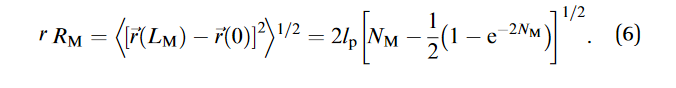

### Simulation Structure Factor:

##### Sources

macroletters

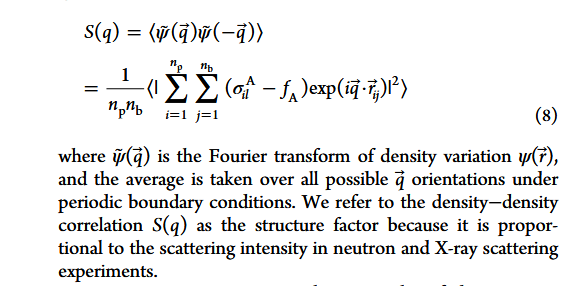

soft matter

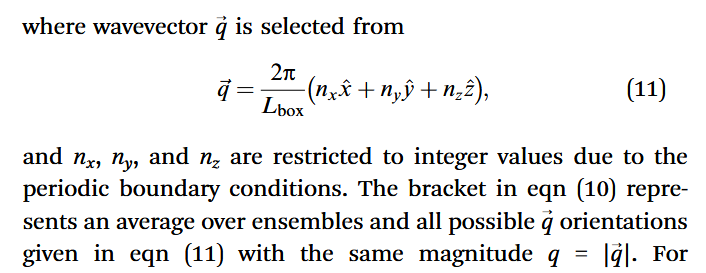

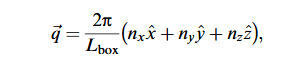

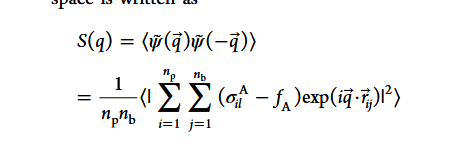

##### Helper functions

In [153]:
def gen_triples_vector(rnge):
    #to make sute itertools.combinations creates all permutations
    lst = []
    for i in range(rnge):
        lst += ([i]*3)
    return lst

In [154]:
def get_mag_vec_map(rnge, l_box = 20):
    comb_dict = {}
    #gen apropraiate vector
    trips = gen_triples_vector(rnge)
    for comb in itertools.combinations(trips, 3):
        comb = np.array(comb)
        comb_mag = np.linalg.norm(comb* (2*np.pi/l_box))
        # if comb_mag not in dictionary
        if comb_mag not in comb_dict:
            comb = comb * (2*np.pi/l_box)
            permutes = list(itertools.permutations(comb))
            for i in range(len(permutes)):
                #permutes[i] = list(permutes[i])
                permutes[i] = np.array(list(permutes[i]))
            permutes = np.unique(np.array(permutes), axis=0)
            comb_dict[comb_mag] = permutes
    return comb_dict

In [155]:
def structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly=1, l_box=20):
    '''
    melt structure factor. Calculates the value of the structure factor for a single magnitude of q (set of q vectors 
    with the same magnitude)  
    q_vectors is a list of vectors with same magnitude
    ''' 
    sum_avg = 0
    for q_vect in q_vectors:
        summ = 0
        A = df.Type - f_A*phi_poly
        B = 1j*np.dot(df.iloc[:,:3], q_vect)
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
    return sum_avg * (1/(n_p*n_b))
    

##### Calculating structure factor

In [ ]:
%%time
#MOST ROBUST SOLUTION
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
sort_mags = np.array(sorted_magnitudes)           

structure_fact_array_list = []
for df_pair in df_chi_list:
    df_list = df_pair[0]
    chi_value = df_pair[1]

    structure_fact_array = np.array([])
    for mag in sorted_magnitudes:
        q_vectors = mag_vects_map[mag]
        sf_average = 0
        for df in df_list: #avging over ensembles
            sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly, l_box=20)
            sf_average += sf/(len(df_list)) 
        structure_fact_array = np.append(structure_fact_array, sf_average)
    structure_fact_array_list.append([structure_fact_array, chi_value])

In [ ]:
(40*L0)/l_kuhn #num kuhn lengths per polymer

In [ ]:
N_M * 8 #num kuhn lengths per polymer

### Theoretical Structure Factor:
##### from 2016 Macromolecules- ABmelt

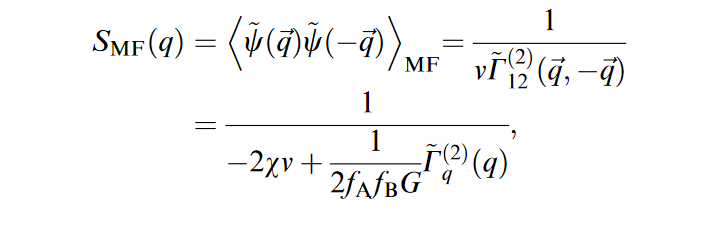

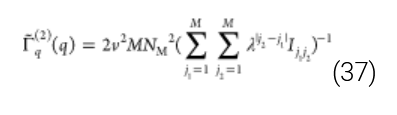

In [ ]:
# R_M_kuhn = np.sqrt(eng.r2wlc(float(N_M))) #end-to-end monomer seperation in kuhn lengths
# mags_kuhn = (np.array(sorted_magnitudes)/R_M_kuhn)*R_M #how Q should be for this function
# Q_matlab = matlab.double(mags_kuhn.tolist()) #function needs it in terms of R_M_kuhn

# num_monomers = 8#*2000
# sinv = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab)
# sinv_arr = np.array([])
# for elem in sinv:
#     sinv_arr= np.append(sinv_arr, float(np.array(elem)))


##### from wlcstat (updated)- ABmelt

In [ ]:
# #alpha_mx = 25 #rigid
# alpha_mx = 11 #flexible
# s2_aa, s2_ab, s2_bb = np.real(s2_wlc_randcopoly(mags_kuhn, float(N_M), num_monomers, f_A, lambda_val, alpha_max = alpha_mx))

In [ ]:
# gamma = (s2_aa + s2_bb + 2*s2_ab)/(s2_aa * s2_bb - s2_ab**2)
# chival = 0
# coef = 1/(2*f_A*(1-f_A)*5)
# structurefactor = np.real(1/(-2*chival + coef*gamma))

###### Calc X_spinodal:

In [ ]:
# # X*v_m
# [kval, sval, d2gam2] = eng.kmaxwlc(matlab.double([num_monomers]), matlab.double([N_M]), matlab.double([f_A]), matlab.double([lambda_val]), nargout=3)
# chi_spin = .5 * sval
# chi_comparison = (chi_spin/5) * 2 #chi = chi_s(no v_m) * 2
# chi_comparison #0.333

# #alt calc assuming its not x*v_m 
# chi_comp = chi_spin * 2
# chi_comp #1.66 is X_s * 2. Not in terms of vm

### Plotting

In [ ]:
sort_magss = np.array(sorted_magnitudes)
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)


#simulation

COLOR = iter(cm.seismic(np.linspace(0, 1, len(structure_fact_array_list)+2)))
for sf_pair in structure_fact_array_list:
    structure_fact_array = sf_pair[0]
    chi_value = sf_pair[1]
    clr = next(COLOR)
    plt.loglog(sort_mags*R_M, structure_fact_array, label = "sim X=" + str(chi_value), zorder=1, color = clr)

    
#2016 MFT

#plt.loglog(mags_kuhn*R_M_kuhn, (1/(sinv_arr)), label = "2016 MFT, X=0", color = "orange", alpha = 1, linestyle='dashed', zorder=5)

#plt.loglog(mags_kuhn*R_M_kuhn, (1/(-2*chi_spin*.8+sinv_arr)), label = "2016 MFT, X=.8X_s", color = "gray", linestyle='dashed', zorder=5)


#wlcstat

#plt.loglog(mags_kuhn*R_M_kuhn, structurefactor*16, label = "wlcstat X=0", alpha = 1, color = "red", linestyle='dotted', linewidth=4, zorder=6)

#plt.loglog(mags_kuhn*R_M_kuhn, np.real(1/(-2*10.6 + coef*gamma))*16, label = "wlcstat X=10.6", color = "orangered", linewidth=4, linestyle='dotted', zorder=8) #*R_M

plt.legend()
plt.xlabel(r'R_m*q') #R_m*
plt.ylabel(r'Structure Factor')
plt.ylim((10e-4, 1e3))
#plt.title("melt structure factor: N_M = 0.05 (rigid), lambda = 0, X = 0")
#plt.title("melt structure factor: N_M = 5 (flexible), lambda = -0.5")
#plt.title(" A-A structure factor: phi_poly = 0.5, nonselective")
plt.title(" A-A structure factor: phi_poly = " + str(phi_poly) + "/n_p = " + str(n_p) + ", selective")
#do full check w/ theory!